In [1]:
%matplotlib qt5
import os
import sys
sys.path.insert(1, 'rh-uitenbroek/python/')
import numpy as np
import xdrlib
from specutils.utils.wcs_utils import air_to_vac
from pathlib import Path
import matplotlib.pyplot as plt
import rhanalyze
from astropy import units

In [60]:
## Compile RH code
## cd rh-uitenbroek
## make
## cd rhf1d
## make

In [36]:
def make_wave_file(outfile, start=None, end=None, step=None, new_wave=None,
                   ewave=None, air=True):
    """
    Writes RH wave file (in xdr format). All wavelengths should be in nm.
    Parameters
    ----------
    start: number
        Starting wavelength.
    end: number
        Ending wavelength (non-inclusive)
    step: number
        Wavelength separation
    new_wave: 1D array
        Alternatively to start/end, one can specify an array of
        wavelengths here.
    outfile: string
        Name of file to write.
    ewave: 1-D array, optional
        Array of existing wavelengths. Program will make discard points
        to make sure no step is enforced using these points too.
    air: boolean, optional
        If true, will at the end convert the wavelengths into vacuum
        wavelengths.
    """
    if new_wave is None:
        new_wave = np.arange(start, end, step)
        if None in [start, end, step]:
            raise ValueError('Must specify either new_wave, or start, end, '
                             'step. Stopping.')
    if step is None:
        step = np.median(np.diff(new_wave))
    if ewave is not None:  # ensure step is kept at most times
        keepers = []
        for w in new_wave:
            if np.min(np.abs(w - ewave)) > step * 0.375:
                keepers.append(w)
        new_wave = np.array(keepers)
    if air:
        # RH uses Edlen (1966) to convert from vacuum to air
        new_wave = air_to_vac(new_wave * units.nm, method='edlen1966',
                              scheme='iteration').value

    # write file
    p = xdrlib.Packer()
    nw = len(new_wave)
    p.pack_int(nw)
    p.pack_farray(nw, new_wave.astype('d'), p.pack_double)
    f = open(outfile, 'wb')
    f.write(p.get_buffer())
    f.close()
    print(("Wrote %i wavelengths to file." % nw))

In [37]:
def watmos_multi(filename, temp, ne, z=None, logtau=None, vz=None, vturb=None,
                 cmass=None, nh=None, id='Model', scale='height', logg=4.44,
                 write_dscale=False, spherical=False):
    """
    Writes file with atmosphere in MULTI format.
    Parameters
    ----------
    filename : str
        Name of file to write.
    temp : 1D array
        Temperature in K.
    ne : 1D array
        Electron density per cm^-3
    z : 1D array, optional
        Height scale in km
    logtau : 1D array, optional
        Log of optical depth at 500 nm scale
    vz : 1D array, optional
        Line of sight velocity in km/s. Positive is upflow.
    vturb : 1D array, optional
        Turbulent velocity in km/s.
    cmass : 1D array, optional
        Column mass scale in g cm^-2
    nh : 2D array, optional
        Hydrogen populations per cm^-3. Shape must be (6, nheight),
        so always 6 levels.
    id : str, optional
        Model ID string
    scale : str, optional
        Type of scale to use. Options are:
            'height' - HEIGHT scale (default)
            'tau'    - TAU(5000) scale
            'mass'   - column mass scale
        Must supply z, logtau, or cmass accordingly.
    logg : float, optional
        Log of gravity. Default is solar (4.44)
    write_dscale : bool, optional
        If True, will write DSCALE file.
        Height scale in km
    spherical : bool, optional
        If True, will write model in spherical geometry
    Returns
    -------
    None. Writes file to disk.
    """
    if scale.lower() == 'height':
        if z is None:
            raise ValueError('watmos_multi: height scale selected '
                             'but z not given!')
        scl = z
        desc = 'HEIGHT (KM)'
    elif scale.lower() == 'tau':
        if logtau is None:
            raise ValueError('watmos_multi: tau scale selected but '
                             'tau not given!')
        scl = logtau
        desc = 'LG TAU(5000)'
    elif scale.lower() == 'mass':
        if cmass is None:
            raise ValueError('watmos_multi: mass scale selected but '
                             'column mass not given!')
        scl = cmass
        desc = 'LOG COLUMN MASS'
    else:
        raise ValueError('watmos_multi: invalid scale: {0}'.format(scale))
    f = open(filename, 'w')
    ndep = len(temp)
    # write 'header'
    f.write(' {0}\n*\n'.format(id))
    f.write(' {0} scale\n'.format(scale).upper())
    f.write('* LG G\n')
    f.write('{0:6.2f}\n'.format(logg))
    if spherical:
        f.write('* Nradius   Ncore    Ninter\n')
        f.write('{0:5d}        8         0\n'.format(ndep))
    else:
        f.write('* NDEP\n')
        f.write('{0:5d}\n'.format(ndep))
    f.write('*  {0}     TEMPERATURE        NE             V            '
            'VTURB\n'.format(desc))
    if vz is None:
        vz = np.zeros(ndep, dtype='f')
    if vturb is None:
        vturb = np.zeros(ndep, dtype='f')
    elif type(vturb) == type(5):   # constant vturb
        vturb = np.zeros(ndep, dtype='f') + vturb
    # write atmosphere
    for i in range(ndep):
        # astype hack to get over numpy bug
        f.write('{0:15.6E}{1:15.6E}{2:15.6E}{3:15.6E}{4:15.6E}'
                '\n'.format(scl[i].astype('d'), temp[i].astype('d'),
                            ne[i].astype('d'), vz[i].astype('d'),
                            vturb[i].astype('d')))
    # if nh given
    if nh is not None:
        if nh.shape != (6, ndep):
            raise ValueError('watmos_multi: nh has incorrect shape. Must be '
                             '6 H levels!')
        f.write('*\n* Hydrogen populations\n')
        f.write('*    nh(1)       nh(2)       nh(3)       nh(4)       nh(5)   '
                'np\n')
        for i in range(ndep):
            ss = ''
            for j in range(nh.shape[0]):
                ss += '{0:12.4E}'.format(nh[j, i].astype('d'))
            f.write(ss + '\n')
    f.close()
    print('--- Wrote multi atmosphere to ' + filename)
    if write_dscale:
        f = open(filename + '.dscale', 'w')
        f.write(' {0}\n*\n'.format(id))
        f.write(' {0} scale\n'.format(scale).upper())
        # setting the second element to zero will force it to be calculated
        # in DPCONV. Will it work for height scale?
        f.write('{0:5d}    {1:.5f}\n'.format(ndep, 0.))
        for i in range(ndep):
            f.write('{0:15.6E}\n'.format(scl[i].astype('d')))
        f.close()
        print(('--- Wrote dscale to ' + filename + '.dscale'))

In [38]:
def create_mag_file(
    Bx, By, Bz,
    write_path,
    height_len
):
    b_filename = 'MAG_FIELD.B'
    xdr = xdrlib.Packer()

    Babs = np.sqrt(
        np.add(
            np.square(Bx),
            np.add(
                np.square(By),
                np.square(Bz)
            )
        )
    )

    Binc = np.arccos(np.divide(Bz, Babs))

    Bazi = np.arctan2(By, Bx)

    shape = (height_len,)

    xdr.pack_farray(
        np.prod(shape),
        Babs.flatten(),
        xdr.pack_double
    )
    xdr.pack_farray(
        np.prod(shape),
        Binc,
        xdr.pack_double
    )
    xdr.pack_farray(
        np.prod(shape),
        Bazi,
        xdr.pack_double
    )

    with open(write_path / b_filename, 'wb') as f:
        f.write(xdr.get_buffer())

In [44]:
falc = {
    'temp': np.array([100000.,  95600.,  90820.,  83890.,  75930.,  71340.,  66150.,
        60170.,  53280.,  49390.,  45420.,  41180.,  36590.,  32150.,
        27970.,  24060.,  20420.,  17930.,  16280.,  14520.,  13080.,
        12190.,  11440.,  10850.,  10340.,   9983.,   9735.,   9587.,
         9458.,   9358.,   9228.,   8988.,   8635.,   8273.,   7970.,
         7780.,   7600.,   7410.,   7220.,   7080.,   6910.,   6740.,
         6570.,   6370.,   6180.,   5950.,   5760.,   5570.,   5380.,
         5160.,   4900.,   4680.,   4560.,   4520.,   4500.,   4510.,
         4540.,   4610.,   4690.,   4780.,   4880.,   4990.,   5060.,
         5150.,   5270.,   5410.,   5580.,   5790.,   5980.,   6180.,
         6340.,   6520.,   6720.,   6980.,   7280.,   7590.,   7900.,
         8220.,   8540.,   8860.,   9140.,   9400.]),
    'ne': np.array([1.251891e+10, 1.304293e+10, 1.366348e+10, 1.467464e+10,
       1.603707e+10, 1.694766e+10, 1.811689e+10, 1.969550e+10,
       2.192829e+10, 2.344633e+10, 2.523785e+10, 2.748732e+10,
       3.043595e+10, 3.394113e+10, 3.804151e+10, 4.291177e+10,
       4.860836e+10, 5.337548e+10, 5.700496e+10, 6.137226e+10,
       6.520094e+10, 6.747161e+10, 6.918466e+10, 6.991762e+10,
       6.967801e+10, 6.848673e+10, 6.599262e+10, 6.265075e+10,
       5.801540e+10, 5.841143e+10, 6.141942e+10, 6.651616e+10,
       7.168647e+10, 7.561758e+10, 7.846423e+10, 8.095357e+10,
       8.445100e+10, 8.838377e+10, 9.185673e+10, 9.612962e+10,
       1.031897e+11, 1.137706e+11, 1.220873e+11, 1.280117e+11,
       1.340907e+11, 1.308237e+11, 1.229867e+11, 1.111659e+11,
       9.742137e+10, 8.363294e+10, 7.544027e+10, 9.114873e+10,
       1.307890e+11, 1.818187e+11, 2.441017e+11, 3.294358e+11,
       4.648930e+11, 7.167248e+11, 1.099721e+12, 1.680047e+12,
       2.557346e+12, 3.880555e+12, 4.803401e+12, 5.984860e+12,
       7.584832e+12, 9.816085e+12, 1.329338e+13, 1.950519e+13,
       2.749041e+13, 4.028244e+13, 5.456858e+13, 7.641340e+13,
       1.099800e+14, 1.719226e+14, 2.789487e+14, 4.446967e+14,
       6.869667e+14, 1.041290e+15, 1.531806e+15, 2.194603e+15,
       2.952398e+15, 3.831726e+15]),
    'z': np.array([ 2.1577834e+03,  2.1565500e+03,  2.1553071e+03,  2.1536606e+03,
        2.1520151e+03,  2.1511741e+03,  2.1503276e+03,  2.1494685e+03,
        2.1486309e+03,  2.1482268e+03,  2.1478523e+03,  2.1474885e+03,
        2.1471353e+03,  2.1468010e+03,  2.1464885e+03,  2.1461958e+03,
        2.1458735e+03,  2.1456216e+03,  2.1454192e+03,  2.1451567e+03,
        2.1448643e+03,  2.1446111e+03,  2.1443284e+03,  2.1439841e+03,
        2.1434993e+03,  2.1428823e+03,  2.1419922e+03,  2.1408701e+03,
        2.1389900e+03,  2.1315779e+03,  2.1174231e+03,  2.0851001e+03,
        2.0367181e+03,  1.9823762e+03,  1.9260653e+03,  1.8769016e+03,
        1.8145767e+03,  1.7344408e+03,  1.6414415e+03,  1.5561520e+03,
        1.4535889e+03,  1.3493253e+03,  1.2566880e+03,  1.1602736e+03,
        1.0689320e+03,  9.7814478e+02,  9.0967389e+02,  8.5059985e+02,
        8.0108759e+02,  7.5170392e+02,  7.0248773e+02,  6.4875623e+02,
        5.9962231e+02,  5.5988654e+02,  5.2496857e+02,  4.9003012e+02,
        4.5023621e+02,  4.0088678e+02,  3.5148038e+02,  3.0201215e+02,
        2.5247437e+02,  2.0286143e+02,  1.7767108e+02,  1.5246886e+02,
        1.2725649e+02,  1.0203552e+02,  7.6806221e+01,  5.1567101e+01,
        3.6398197e+01,  2.1229790e+01,  1.1114420e+01,  9.9941450e-01,
       -9.1153688e+00, -1.9230396e+01, -2.9345213e+01, -3.9459755e+01,
       -4.9573875e+01, -5.9687794e+01, -6.9801674e+01, -7.9915436e+01,
       -9.0029282e+01, -1.0014345e+02]),
    'nH': np.array([[1.35750000e+05, 1.81200000e+05, 2.21800000e+05, 3.00330000e+05,
        4.62420000e+05, 6.93660000e+05, 1.38489988e+06, 4.21580000e+06,
        1.74380000e+07, 4.15070000e+07, 9.04200000e+07, 1.91920000e+08,
        3.95729984e+08, 7.67820032e+08, 1.37809997e+09, 2.27699994e+09,
        3.72249984e+09, 5.22139955e+09, 6.66260019e+09, 8.83040051e+09,
        1.15530004e+10, 1.40979999e+10, 1.71140004e+10, 2.08380006e+10,
        2.58909983e+10, 3.14020004e+10, 3.82319985e+10, 4.55600005e+10,
        5.51020012e+10, 5.79639992e+10, 5.91819981e+10, 6.53440000e+10,
        8.21509980e+10, 1.10360003e+11, 1.50010003e+11, 1.92949993e+11,
        2.62299992e+11, 3.89680005e+11, 6.20999999e+11, 9.53130025e+11,
        1.63579992e+12, 2.93440009e+12, 5.12400032e+12, 9.65349999e+12,
        1.84379989e+13, 3.65049906e+13, 6.14569639e+13, 9.79478784e+13,
        1.47969643e+14, 2.29128721e+14, 3.65724518e+14, 6.20924227e+14,
        1.00580974e+15, 1.47188650e+15, 2.05246340e+15, 2.84348310e+15,
        4.10292186e+15, 6.41285164e+15, 9.92695791e+15, 1.52036903e+16,
        2.30013581e+16, 3.43289220e+16, 4.16587389e+16, 5.00858084e+16,
        5.96425100e+16, 7.03435027e+16, 8.20795910e+16, 9.44361346e+16,
        1.01354494e+17, 1.08302918e+17, 1.12549687e+17, 1.16516553e+17,
        1.20153127e+17, 1.22630757e+17, 1.24327466e+17, 1.25542495e+17,
        1.26726085e+17, 1.27378895e+17, 1.27671021e+17, 1.27852655e+17,
        1.28359882e+17, 1.28869867e+17],
       [6.85369968e-02, 8.97779986e-02, 1.08489998e-01, 1.43680006e-01,
        2.13389993e-01, 3.10030013e-01, 5.91610014e-01, 1.70819998e+00,
        6.75470018e+00, 1.59099998e+01, 3.50309982e+01, 7.75559998e+01,
        1.73669998e+02, 3.80729980e+02, 7.81559998e+02, 1.45050000e+03,
        2.63939990e+03, 3.90590015e+03, 5.11860010e+03, 6.95320020e+03,
        9.22809961e+03, 1.14030000e+04, 1.40200000e+04, 1.73110000e+04,
        2.18760000e+04, 2.69170000e+04, 3.32320000e+04, 3.98800000e+04,
        4.84580000e+04, 5.42600000e+04, 6.17150000e+04, 7.43900000e+04,
        8.97230000e+04, 1.04290000e+05, 1.16529992e+05, 1.26410000e+05,
        1.38860000e+05, 1.52180000e+05, 1.63520000e+05, 1.77020000e+05,
        2.01030000e+05, 2.39680000e+05, 2.72290000e+05, 2.96879969e+05,
        3.22589969e+05, 3.05679938e+05, 2.67069844e+05, 2.11429750e+05,
        1.51069641e+05, 9.19424844e+04, 4.49533242e+04, 2.55029414e+04,
        2.15140703e+04, 2.50533672e+04, 3.10963848e+04, 4.57748477e+04,
        7.86667422e+04, 1.82697453e+05, 4.37975781e+05, 1.07772750e+06,
        2.70643575e+06, 6.89005600e+06, 1.16047200e+07, 2.09879400e+07,
        4.21591720e+07, 8.88773440e+07, 2.01897136e+08, 5.01202688e+08,
        1.02973446e+09, 2.08759962e+09, 3.51752755e+09, 6.09652685e+09,
        1.07906888e+10, 2.12239380e+10, 4.32761569e+10, 8.48861594e+10,
        1.57992665e+11, 2.84545188e+11, 4.89175613e+11, 8.08053572e+11,
        1.22149890e+12, 1.75449807e+12],
       [4.15429994e-02, 5.22960015e-02, 6.18450008e-02, 7.91020021e-02,
        1.10660002e-01, 1.50539994e-01, 2.57319987e-01, 6.38419986e-01,
        2.09879994e+00, 4.33939981e+00, 8.06389999e+00, 1.40380001e+01,
        2.23330002e+01, 3.20880013e+01, 4.07709999e+01, 4.59059982e+01,
        4.95400009e+01, 5.08120003e+01, 5.23950005e+01, 5.59430008e+01,
        6.46370010e+01, 7.39110031e+01, 8.59430008e+01, 1.01610001e+02,
        1.22970001e+02, 1.46940002e+02, 1.76320007e+02, 2.07190002e+02,
        2.47570007e+02, 2.82629974e+02, 3.35329987e+02, 4.42260010e+02,
        6.02459961e+02, 7.92080017e+02, 9.92659973e+02, 1.17899988e+03,
        1.43729993e+03, 1.77270007e+03, 2.13930005e+03, 2.53509985e+03,
        3.17039990e+03, 4.13589990e+03, 5.04979980e+03, 5.88200000e+03,
        6.73489941e+03, 6.64839844e+03, 5.93639697e+03, 4.76189453e+03,
        3.42749194e+03, 2.09518823e+03, 1.02678455e+03, 5.83165771e+02,
        4.92255829e+02, 5.73416809e+02, 7.11938538e+02, 1.04839880e+03,
        1.80310657e+03, 4.19787354e+03, 1.01324248e+04, 2.54014336e+04,
        6.68092344e+04, 1.86452328e+05, 3.35347312e+05, 6.58282625e+05,
        1.46027425e+06, 3.45204600e+06, 8.92027900e+06, 2.56546620e+07,
        5.92417080e+07, 1.35348656e+08, 2.49328544e+08, 4.75372736e+08,
        9.30324480e+08, 2.06570739e+09, 4.79453082e+09, 1.06385172e+10,
        2.21795656e+10, 4.45011190e+10, 8.45440614e+10, 1.53221186e+11,
        2.49859768e+11, 3.83489606e+11],
       [5.20830005e-02, 6.43569976e-02, 7.57860020e-02, 9.64709967e-02,
        1.33359998e-01, 1.76840007e-01, 2.86460012e-01, 6.57159984e-01,
        2.01209998e+00, 4.01550007e+00, 7.20760012e+00, 1.20159998e+01,
        1.79850006e+01, 2.36949997e+01, 2.69669991e+01, 2.68110008e+01,
        2.54309998e+01, 2.60419998e+01, 2.72019997e+01, 2.96340008e+01,
        3.49230003e+01, 4.03619995e+01, 4.58540001e+01, 5.23680000e+01,
        6.00530014e+01, 6.86660004e+01, 7.78010025e+01, 8.66500015e+01,
        9.77360001e+01, 1.08400002e+02, 1.24639999e+02, 1.54919998e+02,
        1.95679993e+02, 2.39600006e+02, 2.82779999e+02, 3.22059998e+02,
        3.76509979e+02, 4.46480011e+02, 5.23320007e+02, 6.11110046e+02,
        7.59450012e+02, 9.95419983e+02, 1.23179993e+03, 1.46589990e+03,
        1.72479993e+03, 1.75529956e+03, 1.60129907e+03, 1.30509851e+03,
        9.49327759e+02, 5.84676758e+02, 2.87845703e+02, 1.64043182e+02,
        1.38867538e+02, 1.62206482e+02, 2.01997040e+02, 2.98674164e+02,
        5.17281067e+02, 1.22248071e+03, 3.03163257e+03, 7.95356055e+03,
        2.23440039e+04, 6.74112969e+04, 1.26114805e+05, 2.57600141e+05,
        5.96315188e+05, 1.47339762e+06, 3.99178675e+06, 1.20994080e+07,
        2.91431620e+07, 6.94633840e+07, 1.32070960e+08, 2.60422896e+08,
        5.27987968e+08, 1.22340826e+09, 2.97126170e+09, 6.88324045e+09,
        1.49323612e+10, 3.11152886e+10, 6.12156948e+10, 1.14603418e+11,
        1.91899828e+11, 3.01459669e+11],
       [7.05880001e-02, 8.63249972e-02, 1.01570003e-01, 1.29319996e-01,
        1.78189993e-01, 2.33009994e-01, 3.64659995e-01, 7.90780008e-01,
        2.29889989e+00, 4.48099995e+00, 7.89109993e+00, 1.28920002e+01,
        1.88160000e+01, 2.40009995e+01, 2.62509995e+01, 2.50119991e+01,
        2.34629993e+01, 2.41410007e+01, 2.61870003e+01, 2.97439995e+01,
        3.74510002e+01, 4.49879990e+01, 5.14519997e+01, 5.84410019e+01,
        6.51320038e+01, 7.25910034e+01, 7.85979996e+01, 8.34150009e+01,
        8.89889984e+01, 9.72200012e+01, 1.11029999e+02, 1.36550003e+02,
        1.70009995e+02, 2.04779999e+02, 2.37570007e+02, 2.66570007e+02,
        3.05989990e+02, 3.54889984e+02, 4.06320007e+02, 4.65209991e+02,
        5.65390015e+02, 7.25219971e+02, 8.81649963e+02, 1.03250000e+03,
        1.19969983e+03, 1.21019971e+03, 1.09979944e+03, 8.94948975e+02,
        6.50788391e+02, 4.01077759e+02, 1.97807037e+02, 1.13095306e+02,
        9.61203766e+01, 1.12663658e+02, 1.40750061e+02, 2.08740021e+02,
        3.62840454e+02, 8.62483154e+02, 2.15600098e+03, 5.72576416e+03,
        1.63718828e+04, 5.05699609e+04, 9.60128438e+04, 1.99452344e+05,
        4.70833531e+05, 1.18790812e+06, 3.29085650e+06, 1.02238950e+07,
        2.51167660e+07, 6.10598120e+07, 1.17817328e+08, 2.35972016e+08,
        4.86310752e+08, 1.14922586e+09, 2.85058355e+09, 6.73666048e+09,
        1.48853658e+10, 3.15642470e+10, 6.31135642e+10, 1.19943111e+11,
        2.03329815e+11, 3.22849669e+11],
       [1.04569999e+10, 1.09400003e+10, 1.15179991e+10, 1.24719995e+10,
        1.37820006e+10, 1.46660004e+10, 1.58060001e+10, 1.73479997e+10,
        1.95070013e+10, 2.09549988e+10, 2.26510008e+10, 2.47609999e+10,
        2.74909983e+10, 3.07200000e+10, 3.44979988e+10, 3.89720023e+10,
        4.42990019e+10, 4.89299968e+10, 5.25340017e+10, 5.69319997e+10,
        6.09100022e+10, 6.34070016e+10, 6.53640008e+10, 6.63719977e+10,
        6.63030006e+10, 6.51459994e+10, 6.25330012e+10, 5.90109983e+10,
        5.40169994e+10, 5.43439995e+10, 5.74850007e+10, 6.28289987e+10,
        6.83339981e+10, 7.27049994e+10, 7.60649974e+10, 7.89769994e+10,
        8.28489974e+10, 8.70149980e+10, 9.05709978e+10, 9.47550044e+10,
        1.01579997e+11, 1.11720006e+11, 1.19510000e+11, 1.24639994e+11,
        1.29279984e+11, 1.23199971e+11, 1.11409938e+11, 9.39658854e+10,
        7.31848294e+10, 4.89087263e+10, 2.45586309e+10, 1.07065559e+10,
        5.98406298e+09, 4.90068941e+09, 4.46644992e+09, 4.87350016e+09,
        6.01958502e+09, 9.50888346e+09, 1.60345948e+10, 2.91364086e+10,
        5.76862126e+10, 1.24664455e+11, 1.98715458e+11, 3.47828126e+11,
        6.90074485e+11, 1.44442917e+12, 3.21013337e+12, 7.49116116e+12,
        1.41918271e+13, 2.56025035e+13, 3.88876154e+13, 5.96307639e+13,
        9.19617845e+13, 1.52423641e+14, 2.57613313e+14, 4.21201269e+14,
        6.60967415e+14, 1.01241170e+15, 1.49979453e+15, 2.15917603e+15,
        2.91369749e+15, 3.78969607e+15]]),
    'cmass': np.array([-4.93574095E+00,-4.93562460E+00,-4.93550158E+00,-4.93532753E+00,-4.93513727E+00,-4.93503189E+00,-4.93491840E+00,-4.93479300E+00,-4.93465710E+00,-4.93458509E+00,-4.93451309E+00,-4.93443680E+00,-4.93435478E+00,-4.93426752E+00,-4.93417501E+00,-4.93407583E+00,-4.93394947E+00,-4.93383646E+00,-4.93373585E+00,-4.93359184E+00,-4.93341446E+00,-4.93324804E+00,-4.93304968E+00,-4.93279409E+00,-4.93241310E+00,-4.93190384E+00,-4.93113708E+00,-4.93013287E+00,-4.92838764E+00,-4.92132998E+00,-4.90772057E+00,-4.87617874E+00,-4.82721663E+00,-4.76904154E+00,-4.70482588E+00,-4.64561558E+00,-4.56636095E+00,-4.45723915E+00,-4.31962919E+00,-4.18329859E+00,-4.00349617E+00,-3.80158830E+00,-3.60500216E+00,-3.37798548E+00,-3.14050150E+00,-2.88156867E+00,-2.67674541E+00,-2.49282169E+00,-2.33261061E+00,-2.16479850E+00,-1.98761845E+00,-1.78171456E+00,-1.58602309E+00,-1.42560005E+00,-1.28381574E+00,-1.14168072E+00,-9.79987085E-01,-7.80323803E-01,-5.83481908E-01,-3.89997512E-01,-2.00394467E-01,-1.52082862E-02, 7.59830400E-02, 1.65459096E-01, 2.52803594E-01, 3.37693125E-01, 4.19847399E-01, 4.98901486E-01, 5.44588983E-01, 5.88704407E-01, 6.17215991E-01, 6.44935131E-01, 6.71832442E-01, 6.97803915E-01, 7.22732782E-01, 7.46601224E-01, 7.69470692E-01, 7.91397929E-01, 8.12412739E-01, 8.32580209E-01, 8.52005064E-01, 8.70782733E-01]),
    'vz': np.zeros(82),
    'vturb': np.zeros(82),
    'id': 'FALC',
    'scale': 'mass'
}

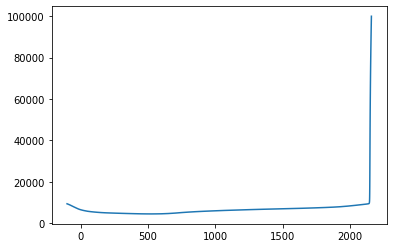

In [16]:
plt.plot(falc['z'], falc['temp'])

(3000.0, 15000.0)

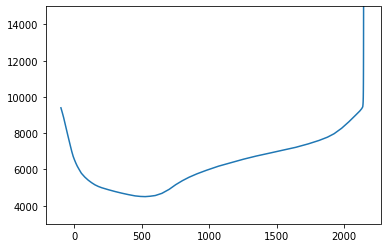

In [17]:
plt.plot(falc['z'], falc['temp'])
plt.ylim(3000, 15000)

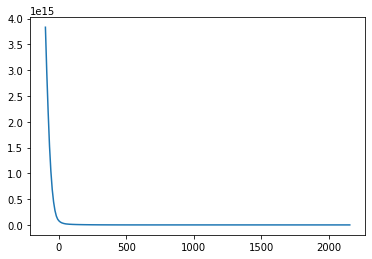

In [18]:
plt.plot(falc['z'], falc['ne'])

(0.0, 200000000000000.0)

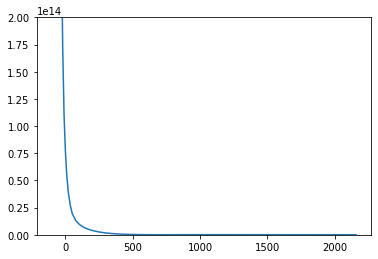

In [19]:
plt.plot(falc['z'], falc['ne'])
plt.ylim(0.0, 0.2e15)

In [2]:
write_path = Path('rh_runs')

In [3]:
run_1 = write_path / 'run_1'

In [14]:
watmos_multi(
        str(run_1 / 'FALC.atmos'),
        falc['temp'],
        falc['ne'],
        cmass=falc['cmass'],
        vz=falc['vz'],
        vturb=falc['vturb'],
        nh=falc['nH'],
        id=falc['id'],
        scale=falc['scale']
    )

--- Wrote multi atmosphere to rh_runs/run_1/FALC.atmos


In [61]:
## cd rh_runs
## cd run_1
## ../../rh-uitenbroek/rhf1d/rhf1d
## ../../rh-uitenbroek/rhf1d/solveray

In [64]:
cwd = os.getcwd()
os.chdir(run_1)
out = rhanalyze.rhout()
os.chdir(cwd)

In [54]:
out

In [55]:
indd = np.where((out.spectrum.waves >= 8536/10) & (out.spectrum.waves<= 8548/10))[0]

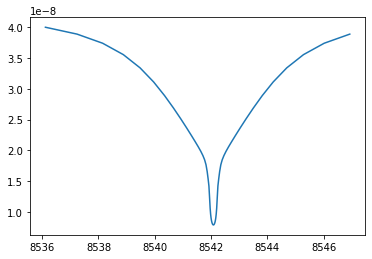

In [56]:
plt.plot(out.spectrum.waves[indd] * 10, out.rays[0].I[indd])

In [57]:
cwd = os.getcwd()
os.chdir(run_1)
!rm -rf *.dat
!rm -rf *.out
!rm -rf spectrum*
!rm -rf background.ray
os.chdir(cwd)

In [59]:
Bz = np.ones(82) * 500 * 1e-4
Bx = np.zeros(82)
By = np.zeros(82)
create_mag_file(Bx, By, Bz, run_1, 82)

In [63]:
## vim keyword.input
## STOKES_MODE = FIELD_FREE
## ../../rh-uitenbroek/rhf1d/rhf1d
## ../../rh-uitenbroek/rhf1d/solveray

In [65]:
cwd = os.getcwd()
os.chdir(run_1)
out = rhanalyze.rhout()
os.chdir(cwd)

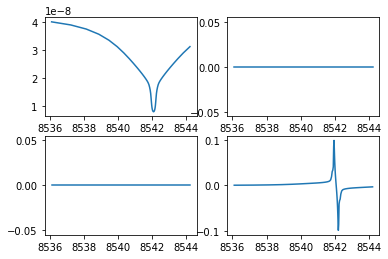

In [67]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].I[indd])
axs[0][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].Q[indd] / out.rays[0].I[indd])
axs[1][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].U[indd] / out.rays[0].I[indd])
axs[1][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].V[indd] / out.rays[0].I[indd])

In [82]:
cwd = os.getcwd()
os.chdir(run_1)
!rm -rf *.dat
!rm -rf *.out
!rm -rf spectrum*
!rm -rf background.ray
!rm -rf MAG_FIELD.B
os.chdir(cwd)

In [83]:
Bz = np.ones(82) * 500 * 1e-4
Bx = np.ones(82) * 300 * 1e-4
By = np.ones(82) * 300 * 1e-4
create_mag_file(Bx, By, Bz, run_1, 82)

In [84]:
## ../../rh-uitenbroek/rhf1d/rhf1d
## ../../rh-uitenbroek/rhf1d/solveray

In [85]:
cwd = os.getcwd()
os.chdir(run_1)
out = rhanalyze.rhout()
os.chdir(cwd)

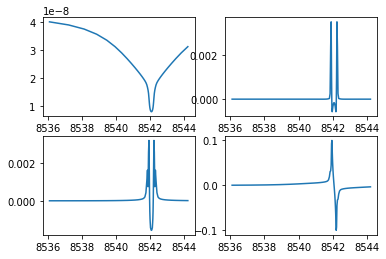

In [86]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].I[indd])
axs[0][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].Q[indd] / out.rays[0].I[indd])
axs[1][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].U[indd] / out.rays[0].I[indd])
axs[1][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].V[indd] / out.rays[0].I[indd])

In [114]:
cwd = os.getcwd()
os.chdir(run_1)
!rm -rf *.dat
!rm -rf *.out
!rm -rf spectrum*
!rm -rf background.ray
os.chdir(cwd)

zsh:1: no matches found: *.dat
zsh:1: no matches found: *.out
zsh:1: no matches found: spectrum*


In [113]:
make_wave_file(run_1 / 'Fe_6301_6302.wave', start=630.1, end=630.3, step=(630.3-630.1)/100)

Wrote 100 wavelengths to file.


In [96]:
## vim kurucz.input
## ../../Atoms/kurucz_6301_6302.input
## WAVETABLE = Fe_6301_6302.wave

In [89]:
## ../../rh-uitenbroek/rhf1d/rhf1d
## ../../rh-uitenbroek/rhf1d/solveray

In [115]:
cwd = os.getcwd()
os.chdir(run_1)
out = rhanalyze.rhout()
os.chdir(cwd)

In [6]:
indd = np.where((out.spectrum.waves >= 8536/10) & (out.spectrum.waves<= 8548/10))[0]
indd2 = np.where((out.spectrum.waves >= 6301/10) & (out.spectrum.waves<= 6303/10))[0]

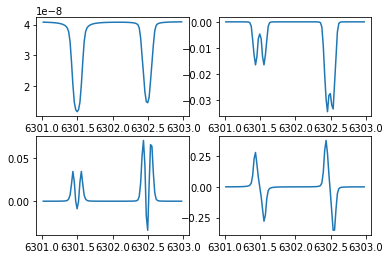

In [118]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd2] * 10, out.rays[0].I[indd2])
axs[0][1].plot(out.spectrum.waves[indd2] * 10, out.rays[0].Q[indd2] / out.rays[0].I[indd2])
axs[1][0].plot(out.spectrum.waves[indd2] * 10, out.rays[0].U[indd2] / out.rays[0].I[indd2])
axs[1][1].plot(out.spectrum.waves[indd2] * 10, out.rays[0].V[indd2] / out.rays[0].I[indd2])

In [141]:
ind_lt_500 = np.where(falc['z'] < 500)[0]
ind_gt_500 = np.where(falc['z'] >= 500)[0]

In [142]:
Bz = np.zeros(82)
Bz[ind_lt_500] = 500 * 1e-4
Bz[ind_gt_500] = -500 * 1e-4
Bx = np.zeros(82)
By = np.zeros(82)
create_mag_file(Bx, By, Bz, run_1, 82)

In [143]:
cwd = os.getcwd()
os.chdir(run_1)
!rm -rf *.dat
!rm -rf *.out
!rm -rf spectrum*
!rm -rf background.ray
os.chdir(cwd)

In [123]:
## ../../rh-uitenbroek/rhf1d/rhf1d
## ../../rh-uitenbroek/rhf1d/solveray

In [4]:
cwd = os.getcwd()
os.chdir(run_1)
out = rhanalyze.rhout()
os.chdir(cwd)

In [7]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd2] * 10, out.rays[0].I[indd2])
axs[0][1].plot(out.spectrum.waves[indd2] * 10, out.rays[0].Q[indd2] / out.rays[0].I[indd2])
axs[1][0].plot(out.spectrum.waves[indd2] * 10, out.rays[0].U[indd2] / out.rays[0].I[indd2])
axs[1][1].plot(out.spectrum.waves[indd2] * 10, out.rays[0].V[indd2] / out.rays[0].I[indd2])

In [8]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].I[indd])
axs[0][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].Q[indd] / out.rays[0].I[indd])
axs[1][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].U[indd] / out.rays[0].I[indd])
axs[1][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].V[indd] / out.rays[0].I[indd])

In [10]:
rayno  = out.geometry.Nrays-1

In [11]:
rayno

4

In [16]:
lcore_8542 = np.argmin(np.abs(out.spectrum.waves - 8542.09/10))
lcore_6302_5 = np.argmin(np.abs(out.spectrum.waves - 6302.5/10))

205

In [25]:
cwd = os.getcwd()
os.chdir(run_1)
out.opacity.read(lcore_8542, rayno)
out.opacity.Source()
out.opacity.Planck()
plt.plot(out.geometry.height / 1e3, out.opacity.S, label='S_8542')
plt.plot(out.geometry.height / 1e3, out.opacity.Bp, '.', label='Bp')
plt.legend()
plt.yscale('log')
os.chdir(cwd)

In [19]:
out.geometry.tau500

array([3.92219960e-06, 3.92324830e-06, 3.92435234e-06, 3.92590448e-06,
       3.92758545e-06, 3.92850859e-06, 3.92949552e-06, 3.93057660e-06,
       3.93173688e-06, 3.93234717e-06, 3.93295417e-06, 3.93359360e-06,
       3.93427625e-06, 3.93499577e-06, 3.93574873e-06, 3.93654256e-06,
       3.93753118e-06, 3.93839256e-06, 3.93914113e-06, 3.94018432e-06,
       3.94142816e-06, 3.94255766e-06, 3.94386009e-06, 3.94547418e-06,
       3.94776459e-06, 3.95065617e-06, 3.95473112e-06, 3.95967069e-06,
       3.96748310e-06, 3.99739124e-06, 4.05646136e-06, 4.20154155e-06,
       4.43896971e-06, 4.72768887e-06, 5.04614778e-06, 5.33870977e-06,
       5.73062238e-06, 6.26975556e-06, 6.94145261e-06, 7.60518189e-06,
       8.48971551e-06, 9.53723224e-06, 1.06449458e-05, 1.20436908e-05,
       1.37620691e-05, 1.61580749e-05, 1.87280047e-05, 2.18414132e-05,
       2.54561100e-05, 3.05622150e-05, 3.84611226e-05, 5.55019556e-05,
       9.14289483e-05, 1.52865962e-04, 2.55672536e-04, 4.44029089e-04,
      

In [33]:
vz = np.interp(falc['z'], [-500, 0, 500, 1000, 1500, 1800, 2157], [0, 4, 3, 0, -5, 10, 16])

In [34]:
plt.plot(falc['z'], vz)

In [46]:
watmos_multi(
        str('FALC.atmos'),
        falc['temp'],
        falc['ne'],
        cmass=falc['cmass'],
        vz=vz,
        vturb=falc['vturb'],
        nh=falc['nH'],
        id=falc['id'],
        scale=falc['scale']
    )

--- Wrote multi atmosphere to FALC.atmos


In [47]:
cwd = os.getcwd()
os.chdir(run_1)
!rm -rf *.dat
!rm -rf *.out
!rm -rf spectrum*
!rm -rf background.ray
os.chdir(cwd)

In [ ]:
## ../../rh-uitenbroek/rhf1d/rhf1d
## ../../rh-uitenbroek/rhf1d/solveray

In [48]:
cwd = os.getcwd()
os.chdir(run_1)
out = rhanalyze.rhout()
os.chdir(cwd)

In [49]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].I[indd])
axs[0][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].Q[indd] / out.rays[0].I[indd])
axs[1][0].plot(out.spectrum.waves[indd] * 10, out.rays[0].U[indd] / out.rays[0].I[indd])
axs[1][1].plot(out.spectrum.waves[indd] * 10, out.rays[0].V[indd] / out.rays[0].I[indd])

In [50]:
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(out.spectrum.waves[indd2] * 10, out.rays[0].I[indd2])
axs[0][1].plot(out.spectrum.waves[indd2] * 10, out.rays[0].Q[indd2] / out.rays[0].I[indd2])
axs[1][0].plot(out.spectrum.waves[indd2] * 10, out.rays[0].U[indd2] / out.rays[0].I[indd2])
axs[1][1].plot(out.spectrum.waves[indd2] * 10, out.rays[0].V[indd2] / out.rays[0].I[indd2])